In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-07-23 22:11:47.325758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 22:11:47.325888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 22:11:47.466222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_rows', None)  # To display all rows 
pd.set_option('display.max_columns', None)  # To display all columns

In [3]:
# Paths to datasets
train_dir = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training'
val_dir = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation'
test_dir = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test'

train_labels_path = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
val_labels_path = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'
test_labels_path = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'

In [4]:
# Load labels
train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

In [5]:
# Print dataset shapes
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (1920, 47)
Validation labels shape: (640, 47)
Test labels shape: (640, 47)


In [6]:
# Display sample data
print("Sample train labels:")
print(train_labels.head())

Sample train labels:
   ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  LS  MS  CSR  ODC  \
0   1             1   1     0   0   0    0     0     0    0   0   0    0    0   
1   2             1   1     0   0   0    0     0     0    0   0   0    0    0   
2   3             1   1     0   0   0    0     0     0    0   0   0    0    0   
3   4             1   0     0   1   0    0     0     0    0   0   0    0    1   
4   5             1   1     0   0   0    0     0     0    0   1   0    0    0   

   CRVO  TV  AH  ODP  ODE  ST  AION  PT  RT  RS  CRS  EDN  RPEC  MHL  RP  CWS  \
0     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
1     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
2     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
3     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   
4     0   0   0    0    0   0     0   0   0   0    0    0     0    0   0    0   

   CB

In [7]:

# EDA
disease_counts = train_labels.iloc[:, 2:].sum().sort_values(ascending=False)
fig = px.bar(disease_counts, title="Disease Distribution in Training Set")
fig.show()

In [8]:
# Data Preprocessing
def load_images_and_labels(image_dir, labels_df):
    images = []
    labels = []
    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['ID']}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224)) # Resize images to 224x224
            images.append(img)
            labels.append(row['Disease_Risk'])
    return np.array(images), np.array(labels)

# Load images and labels
X_train, y_train = load_images_and_labels(train_dir, train_labels)
X_val, y_val = load_images_and_labels(val_dir, val_labels)
X_test, y_test = load_images_and_labels(test_dir, test_labels)

In [9]:
# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [10]:
# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [12]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



60/60 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7463 - loss: 0.6644 - val_accuracy: 0.7906 - val_loss: 0.5006
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8013 - loss: 0.4779 - val_accuracy: 0.7906 - val_loss: 0.4791
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7933 - loss: 0.4724 - val_accuracy: 0.7906 - val_loss: 0.4960
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7993 - loss: 0.4703 - val_accuracy: 0.7906 - val_loss: 0.4681
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7939 - loss: 0.4607 - val_accuracy: 0.7906 - val_loss: 0.4683
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7804 - loss: 0.4954 - val_accuracy: 0.7906 - val_loss: 0.4995
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.7841 - loss: 0.4488 - val_accuracy: 0.7906 - val_loss: 0.5774
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7929 - loss: 0.4863 - val_accuracy: 0.7906 - val_loss: 0.

In [13]:
# Model Evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step
Accuracy: 0.85625
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.38      0.53       134
           1       0.86      0.98      0.92       506

    accuracy                           0.86       640
   macro avg       0.85      0.68      0.72       640
weighted avg       0.86      0.86      0.83       640



In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig = px.imshow(cm, text_auto=True, title="Confusion Matrix")
fig.show()

In [15]:
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

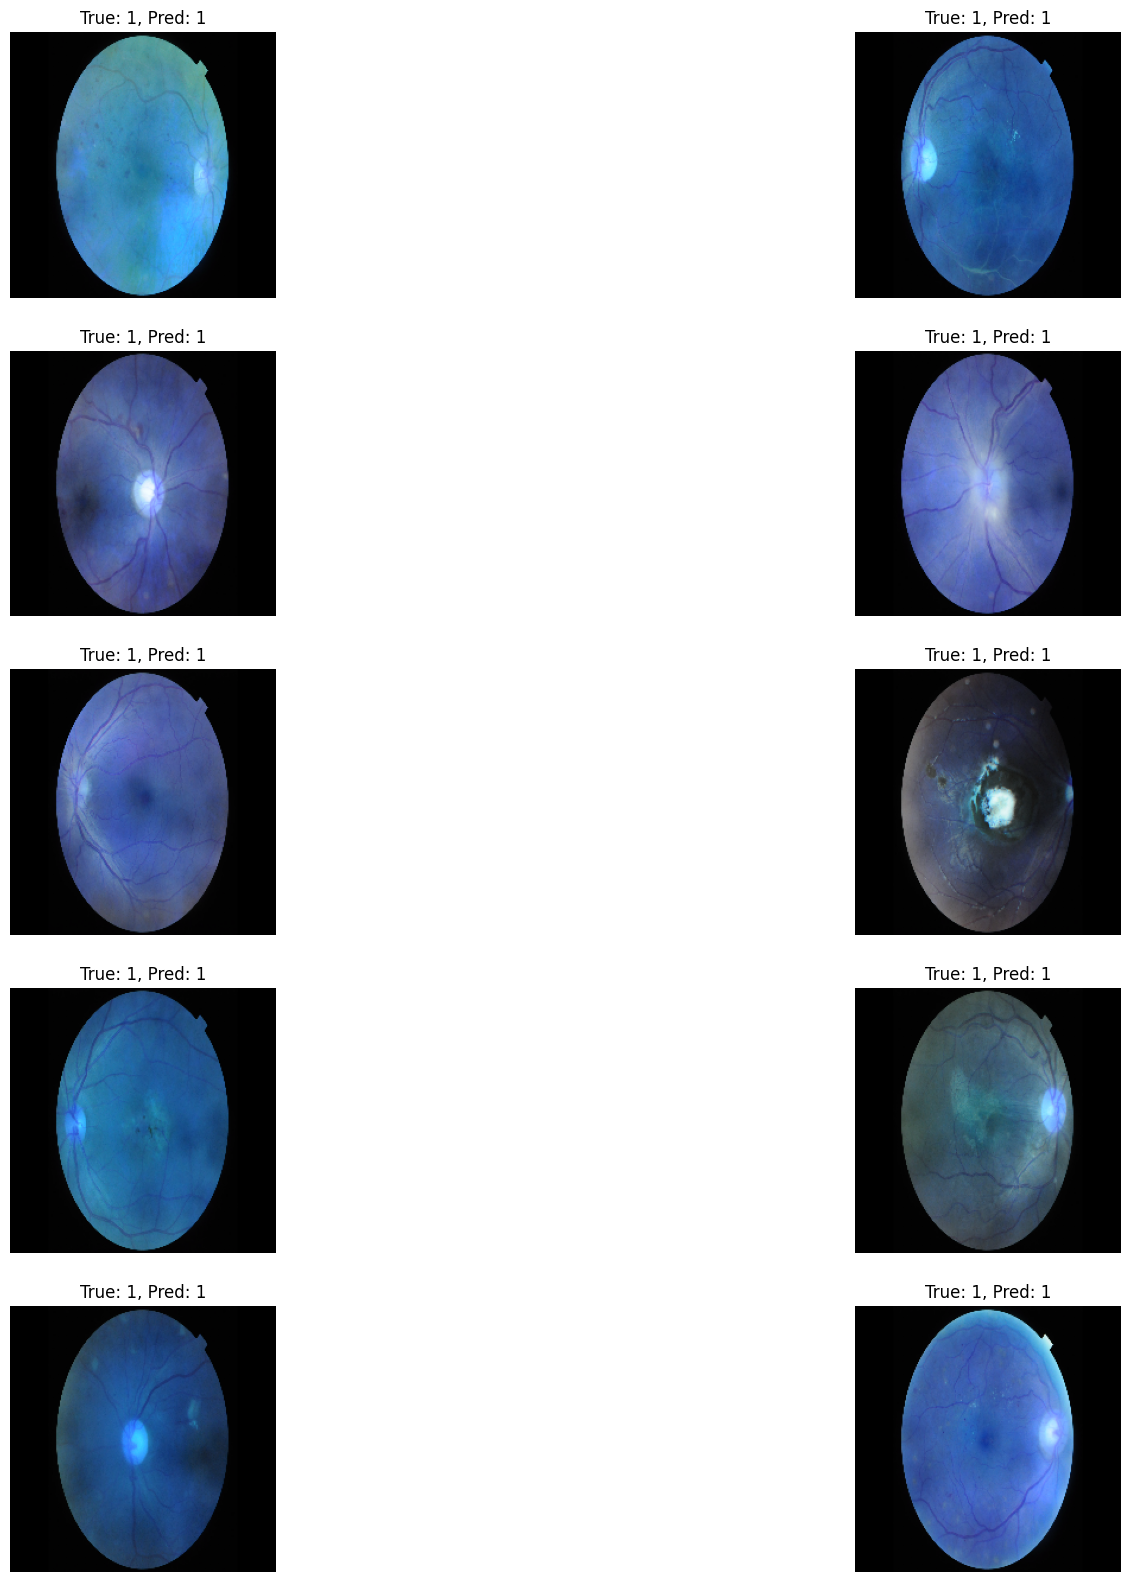

In [16]:
# Display 10 samples with actual and predicted labels
def display_samples(images, true_labels, pred_labels, sample_count=10):
    plt.figure(figsize=(20, 20))
    for i in range(sample_count):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i][0]}")
        plt.axis('off')
    plt.show()

display_samples(X_test, y_test, y_pred, sample_count=10)

In [17]:
# Save the model
model.save('/kaggle/working/retinal_disease_classification_model.h5')